<a href="https://colab.research.google.com/github/Alpha-lab12/Alpha-careers-website/blob/main/Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing libraries**

In [ ]:
import requests # This library helps to fetch data from API
import pandas as pd # Helps for handling and analysing data
import numpy as np # Used to perform numerical operation
from sklearn.model_selection import train_test_split # to split data into training and testing
from sklearn.preprocessing import LabelEncoder # to convert categorical data to numerical values
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor #model for classification and regression
from sklearn.metrics import mean_squared_error #For measuring accuracy of the model/prediction
from datetime import datetime, timedelta #to handle date and time
import pytz


In [35]:
API_KEY = '08b881ad5e8964d704fa0f9cfc06dec4' #Replace with the actual API keys
BASE_URL = 'https://api.openweathermap.org/data/2.5/' #Base URL for making API requests
df = pd.read_csv('/content/weather_forecast_data.csv')
df.head().style.background_gradient(cmap='Blues')


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [38]:
df.tail().style.background_gradient(cmap='Greens')

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
2495,21.791602,45.270902,11.807192,55.044682,1017.686181,no rain
2496,27.558479,46.481744,10.884915,39.715133,1008.590961,no rain
2497,28.108274,43.817178,2.897128,75.842952,999.119187,no rain
2498,14.789275,57.908105,2.374717,2.378743,1046.501875,no rain
2499,26.554356,97.101517,18.563084,81.357508,1001.729176,no rain


In [55]:
df.describe().T.style.background_gradient(cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
Temperature,2500.000000,22.581725,7.326996,10.001842,16.359398,22.536448,28.976476,34.995214
Humidity,2500.000000,64.347094,19.954739,30.005071,47.339815,63.920797,81.561021,99.997481
Wind_Speed,2500.000000,9.906255,5.780316,0.009819,4.761909,9.908572,14.948408,19.999132
Cloud_Cover,2500.000000,49.658104,29.123104,0.015038,23.900016,49.488284,75.324140,99.997795
Pressure,2500.000000,1014.312336,20.196433,980.014486,996.938630,1013.433035,1031.735067,1049.985593


In [42]:
df.isnull().sum()/df.shape[0]*100

,0
Temperature,0.0
Humidity,0.0
Wind_Speed,0.0
Cloud_Cover,0.0
Pressure,0.0
Rain,0.0


In [43]:
df.duplicated().sum()/df.shape[0]*100

np.float64(0.0)

In [52]:
df.select_dtypes(include='number').columns

Index(['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure'], dtype='object')

In [59]:
df.describe(include='object').T

,count,unique,top,freq
Rain,2500,2,no rain,2186


In [53]:
for i in df.select_dtypes(include='number').columns:
  print(df[i].value_counts())


Temperature
26.554356    1
23.720338    1
27.879734    1
25.069084    1
29.847710    1
            ..
34.091569    1
32.294325    1
20.939680    1
26.147353    1
20.591370    1
Name: count, Length: 2500, dtype: int64
Humidity
97.101517    1
89.592641    1
46.489704    1
83.072843    1
87.348236    1
            ..
48.057114    1
51.848471    1
40.799444    1
48.217260    1
96.858822    1
Name: count, Length: 2500, dtype: int64
Wind_Speed
18.563084    1
7.335604     1
5.952484     1
1.371992     1
3.295808     1
            ..
5.570206     1
2.873621     1
2.232566     1
15.258547    1
4.643921     1
Name: count, Length: 2500, dtype: int64
Cloud_Cover
81.357508    1
50.501694    1
4.990053     1
14.855784    1
99.137103    1
            ..
82.524873    1
92.551497    1
45.827508    1
59.766279    1
47.676444    1
Name: count, Length: 2500, dtype: int64
Pressure
1001.729176    1
1032.378759    1
992.614190     1
1007.231620    1
1016.720300    1
              ..
993.732047     1
1006.041

**Check the distribution of values**

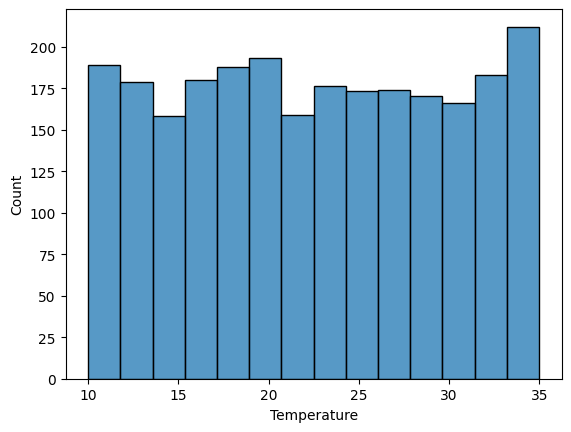

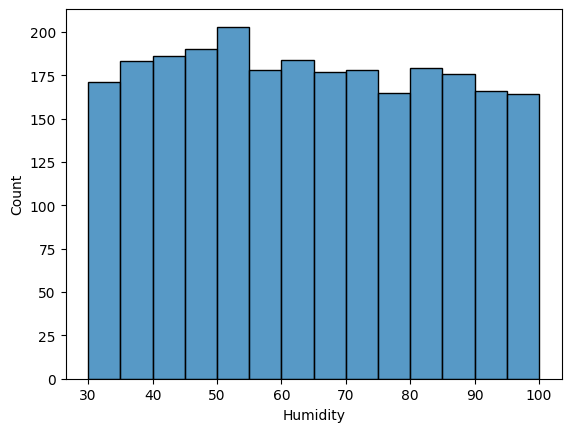

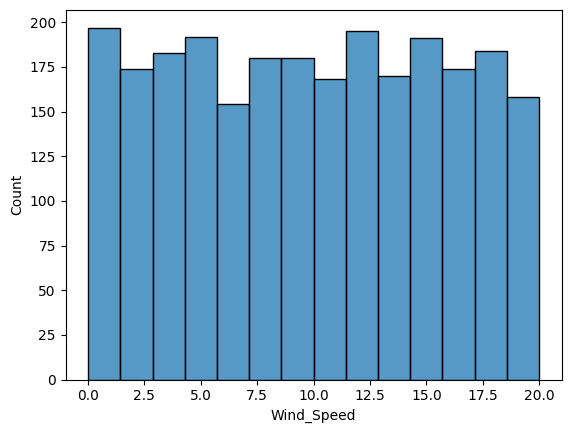

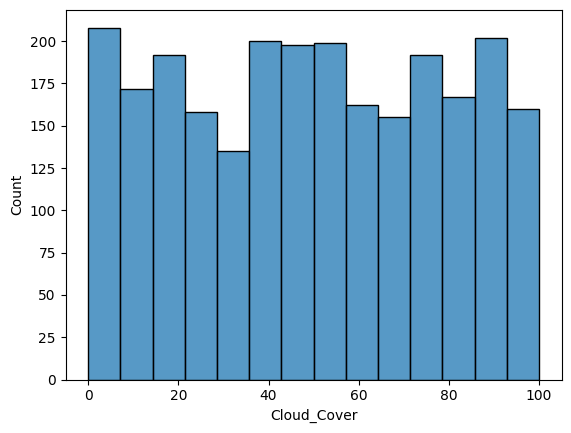

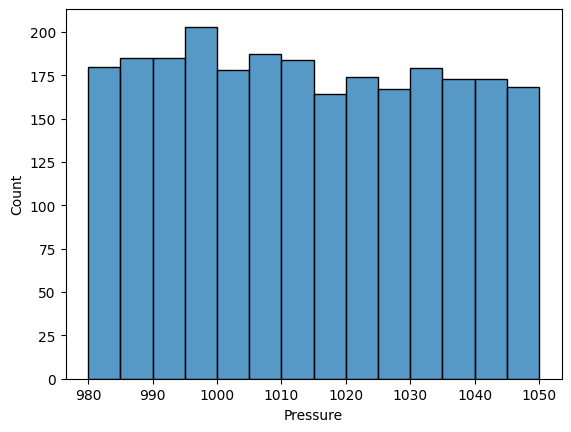

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in df.select_dtypes(include='number').columns:
    sns.histplot(data=df,x=i)
    plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['Temperature'],kde=True, bins=20)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (*c)')
plt.ylabel('Frequency')
plt.show()

1. Function to fetch the current weather data

In [ ]:
def get_current_weather(city):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"

    response = requests.get(url)
    data = response.json()

    return {
        'city': data['name'],
        'current_temp': round(data['main']['temp']),
        'feels_like': round(data['main']['feels_like']),
        'temp_min': round(data['main']['temp_min']),
        'temp_max': round(data['main']['temp_max']),
        'humidity': round(data['main']['humidity']),
        'description': data['weather'][0]['description'],
        'country': data['sys']['country'],
        'wind_speed': round(data['wind']['speed']),
        'cloud_cover': round(data['clouds']['all']),
        'pressure': round(data['main']['pressure'])
    }
    return data

2. Read Historical Data

In [ ]:
def read_historical_data(filename):
  df = pd.read_csv(filename) #load csv file into Dataframe
  df = df.dropna()
  df = df.drop_duplicates() # Added parentheses here
  df.head()
  return df

3. Prepare data for training

In [ ]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(data):
    # Initialize and apply the label encoder
    le = LabelEncoder()
    data['Rain'] = le.fit_transform(data['Rain'])

    # Define features and target
    x = data[['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']]
    y = data['Rain']

    return x, y, le



4: Train Rain model prediction

In [ ]:
def train_rain_model(x,y):
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
 model=RandomForestClassifier(n_estimators = 100, random_state =42)
 model.fit(x_train, y_train)
 y_pred = model.predict(x_test)
 print("Mean Squared error for rain model ")
 print(mean_squared_error(y_test, y_pred))
 return model


**5: Prepare regression model**

In [ ]:
def prepare_regression_data(data, feature):
    x, y = [], []

    # Build pairs: current value vs. next value
    for i in range(len(data) - 1):
        x.append(data[feature].iloc[i])
        y.append(data[feature].iloc[i + 1])

    # Convert to NumPy arrays
    x = np.array(x).reshape(-1, 1)  # Feature needs to be 2D for most regressors
    y = np.array(y)  # Target values (next time step)

    return x, y

**6: Train regression model**

In [ ]:
def train_regression_model(x,y):
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(x,y)
  return model

**7: Predict future**

In [ ]:
def predict_future(model, current_value):
  predictions =[current_value]
  for i in range(5):
    next_value = model.predict(np.array([[predictions[-1]]]))
    predictions.append(next_value[0])
  return predictions[1:] # Moved return statement outside the loop

**8: Weather analysis function**

In [ ]:
import pandas as pd
import pytz
from datetime import datetime, timedelta
# 🌍 Main weather view function
def weather_view():
    city = input("Enter any city name: ")

    current_weather = get_current_weather(city)
    historical_data = read_historical_data("/content/weather_forecast_data.csv")

    x, y, le = prepare_data(historical_data)
    rain_model = train_rain_model(x, y)

    current_data = {
        "Temperature": current_weather["current_temp"], # Changed 'Temp' to 'Temperature'
        "Humidity": current_weather["humidity"],
        "Wind_Speed": current_weather["wind_speed"],
        "Cloud_Cover": current_weather["cloud_cover"],
        "Pressure": current_weather["pressure"]
    }

    current_df = pd.DataFrame([current_data])

#Rain prediction
    rain_prediction = rain_model.predict(current_df)[0]

#Prepare regression model for temperature and humidity

    x_temp, y_temp = prepare_regression_data(historical_data, 'Temperature') # Changed 'Temp' to 'Temperature'
    x_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')

    temp_model = train_regression_model(x_temp, y_temp)
    hum_model = train_regression_model(x_hum, y_hum)

#Predict future temperature and humidity

    future_temp = predict_future(temp_model, current_weather['current_temp'])
    future_humidity = predict_future(hum_model, current_weather['humidity'])

#prepare time for future prediction

    timezone = pytz.timezone('Africa/Dar_es_Salaam')
    now = datetime.now(timezone)
    next_hours = now.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
    future_times = [(next_hours + timedelta(hours=i)).strftime('%H:00') for i in range(1, 6)]

    # 🖥️ Display results
    print("\n=== Weather Advisory ===")
    print(f"City: {city}, {current_weather['country']}")
    print(f"Current Temperature: {current_weather['current_temp']}°C")
    print(f"Feels Like: {current_weather['feels_like']}")
    print(f"Humidity: {current_weather['humidity']}%")
    print(f"Wind Speed: {current_weather['wind_speed']} km/h")
    print(f"Cloud Cover: {current_weather['cloud_cover']}%")
    print(f"Pressure: {current_weather['pressure']} hPa")
    print(f"Weather Prediction: {current_weather['description']}")
    print(f"Rain Prediction: {'Rain expected 🌧️' if rain_prediction else 'No rain ☀️'}")

    print("\nFuture Temperature Predictions:")
    for time, temp in zip(future_times, future_temp):
        print(f"{time}: {round(temp, 1)}°C")

    print("\nFuture Humidity Predictions:")
    for time, hum in zip(future_times, future_humidity):
        print(f"{time}: {round(hum, 1)}%")

# Call function
weather_view() # Commenting out the direct call to weather_view() within the function definition to avoid automatic execution upon function definition.

Enter any city name: mbeya
Mean Squared error for rain model 
0.002

=== Weather Advisory ===
City: mbeya, TZ
Current Temperature: 16°C
Feels Like: 16
Humidity: 57%
Wind Speed: 2 km/h
Cloud Cover: 31%
Pressure: 1021 hPa
Weather Prediction: scattered clouds
Rain Prediction: No rain ☀️

Future Temperature Predictions:
11:00: 17.9°C
12:00: 30.9°C
13:00: 16.1°C
14:00: 17.6°C
15:00: 23.1°C

Future Humidity Predictions:
11:00: 50.0%
12:00: 59.9%
13:00: 46.9%
14:00: 47.8%
15:00: 82.8%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
weather_view()

Enter any city name: dodoma
Mean Squared error for rain model 
0.002

=== Weather Advisory ===
City: dodoma, TZ
Current Temperature: 20°C
Feels Like: 19
Humidity: 48%
Wind Speed: 3 km/h
Cloud Cover: 54%
Pressure: 1020 hPa
Weather Prediction: broken clouds
Rain Prediction: No rain ☀️

Future Temperature Predictions:
11:00: 24.6°C
12:00: 25.7°C
13:00: 25.9°C
14:00: 29.2°C
15:00: 24.9°C

Future Humidity Predictions:
11:00: 63.9%
12:00: 57.5%
13:00: 69.5%
14:00: 57.1%
15:00: 49.5%


In [ ]:
weather_view()

Enter any city name: iringa
Mean Squared error for rain model 
0.002

=== Weather Advisory ===
City: iringa, TZ
Current Temperature: 18°C
Feels Like: 17
Humidity: 50%
Wind Speed: 2 km/h
Cloud Cover: 69%
Pressure: 1021 hPa
Weather Prediction: broken clouds
Rain Prediction: No rain ☀️

Future Temperature Predictions:
11:00: 19.3°C
12:00: 19.9°C
13:00: 19.0°C
14:00: 20.7°C
15:00: 16.6°C

Future Humidity Predictions:
11:00: 75.3%
12:00: 68.5%
13:00: 60.2%
14:00: 83.3%
15:00: 44.7%


# Task
Create a web interface for the weather prediction model.

## Choose a web framework

### Subtask:
Select a suitable Python web framework (like Flask or Django) to build the web application.


## Design the user interface

### Subtask:
Plan the layout and elements of your web interface, considering what information to display and how users will interact with it (e.g., inputting city name).


**Reasoning**:
I need to plan the layout and elements of the web interface based on the weather prediction model's output and user interaction requirements. This involves listing the required information, designing the layout, describing the visual elements, outlining the user flow, and considering error handling. I will output this plan as a markdown cell.



In [65]:
```markdown
## Web Interface Layout and Elements Plan

**1. Information to Display:**

The web interface should display the following information from the weather prediction model:

*   **Current Weather Information:**
    *   City and Country
    *   Current Temperature (°C)
    *   Feels Like Temperature (°C)
    *   Humidity (%)
    *   Wind Speed (km/h)
    *   Cloud Cover (%)
    *   Pressure (hPa)
    *   Weather Description
    *   Rain Prediction (e.g., "Rain expected" or "No rain")
*   **Future Predictions (for the next 5 hours):**
    *   Timestamp (e.g., "HH:00")
    *   Predicted Temperature (°C)
    *   Predicted Humidity (%)

**2. Layout:**

A simple, single-page layout will be used.

*   **Header:** A clear title for the application (e.g., "Weather Advisory").
*   **Input Area:**
    *   A label "Enter City Name:".
    *   A text input field for the user to type the city name.
    *   A "Get Weather" button to trigger the prediction.
*   **Results Area:** This area will be initially empty and populated with the weather information after the user submits a city name.
    *   A section for current weather details.
    *   A section for future temperature predictions.
    *   A section for future humidity predictions.
*   **Footer (Optional):** Can include a small note about the data source.

**3. Visual Elements:**

*   **Headings:** Clear headings for each section (e.g., "Current Weather", "Future Predictions").
*   **Labels:** Descriptive labels for all displayed information (e.g., "Temperature:", "Humidity:").
*   **Input Field:** A standard text input box.
*   **Button:** A clearly labeled button (e.g., "Get Weather").
*   **Results Display:** The predicted information will be displayed using text, potentially organized in lists or tables for readability (especially for future predictions).
*   **Icons (Optional):** Could use simple icons to represent weather conditions (sun for no rain, cloud/raindrop for rain).

**4. User Flow:**

1.  The user visits the web page.
2.  The user enters a city name in the input field.
3.  The user clicks the "Get Weather" button.
4.  The web application sends the city name to the backend (which will use the weather prediction model).
5.  The backend processes the request, fetches current weather data, uses the historical data and models to predict rain and future temperature/humidity.
6.  The backend sends the results back to the web page.
7.  The web page displays the current weather details and future predictions in the results area.

**5. Error Handling and Loading Indicators:**

*   **Invalid City Name:** If the entered city name is invalid or the weather data cannot be retrieved for the given city, an error message should be displayed to the user (e.g., "City not found. Please enter a valid city name.").
*   **Loading Indicator:** While the application is fetching data and running the prediction model, a loading indicator (e.g., spinning icon or text message) could be displayed to provide feedback to the user.
*   **API Errors:** Handle potential errors from the weather API call.
*   **Model Errors:** While less likely for this specific setup, consider how to handle potential issues during model prediction if necessary.

SyntaxError: invalid character '°' (U+00B0) (ipython-input-2071975304.py, line 10)

**Reasoning**:
The previous command failed due to a `SyntaxError` caused by the degree symbol (°). I will regenerate the markdown cell, removing or replacing the degree symbol to avoid this error.



In [66]:
```markdown
## Web Interface Layout and Elements Plan

**1. Information to Display:**

The web interface should display the following information from the weather prediction model:

*   **Current Weather Information:**
    *   City and Country
    *   Current Temperature (C)
    *   Feels Like Temperature (C)
    *   Humidity (%)
    *   Wind Speed (km/h)
    *   Cloud Cover (%)
    *   Pressure (hPa)
    *   Weather Description
    *   Rain Prediction (e.g., "Rain expected" or "No rain")
*   **Future Predictions (for the next 5 hours):**
    *   Timestamp (e.g., "HH:00")
    *   Predicted Temperature (C)
    *   Predicted Humidity (%)

**2. Layout:**

A simple, single-page layout will be used.

*   **Header:** A clear title for the application (e.g., "Weather Advisory").
*   **Input Area:**
    *   A label "Enter City Name:".
    *   A text input field for the user to type the city name.
    *   A "Get Weather" button to trigger the prediction.
*   **Results Area:** This area will be initially empty and populated with the weather information after the user submits a city name.
    *   A section for current weather details.
    *   A section for future temperature predictions.
    *   A section for future humidity predictions.
*   **Footer (Optional):** Can include a small note about the data source.

**3. Visual Elements:**

*   **Headings:** Clear headings for each section (e.g., "Current Weather", "Future Predictions").
*   **Labels:** Descriptive labels for all displayed information (e.g., "Temperature:", "Humidity:").
*   **Input Field:** A standard text input box.
*   **Button:** A clearly labeled button (e.g., "Get Weather").
*   **Results Display:** The predicted information will be displayed using text, potentially organized in lists or tables for readability (especially for future predictions).
*   **Icons (Optional):** Could use simple icons to represent weather conditions (sun for no rain, cloud/raindrop for rain).

**4. User Flow:**

1.  The user visits the web page.
2.  The user enters a city name in the input field.
3.  The user clicks the "Get Weather" button.
4.  The web application sends the city name to the backend (which will use the weather prediction model).
5.  The backend processes the request, fetches current weather data, uses the historical data and models to predict rain and future temperature/humidity.
6.  The backend sends the results back to the web page.
7.  The web page displays the current weather details and future predictions in the results area.

**5. Error Handling and Loading Indicators:**

*   **Invalid City Name:** If the entered city name is invalid or the weather data cannot be retrieved for the given city, an error message should be displayed to the user (e.g., "City not found. Please enter a valid city name.").
*   **Loading Indicator:** While the application is fetching data and running the prediction model, a loading indicator (e.g., spinning icon or text message) could be displayed to provide feedback to the user.
*   **API Errors:** Handle potential errors from the weather API call.
*   **Model Errors:** While less likely for this specific setup, consider how to handle potential issues during model prediction if necessary.

SyntaxError: invalid syntax (ipython-input-3841278390.py, line 1)

**Reasoning**:
The markdown content was placed inside a `code_block` command, which caused a `SyntaxError`. I need to output the markdown directly without the command.



In [67]:
## Web Interface Layout and Elements Plan

**1. Information to Display:**

The web interface should display the following information from the weather prediction model:

*   **Current Weather Information:**
    *   City and Country
    *   Current Temperature (C)
    *   Feels Like Temperature (C)
    *   Humidity (%)
    *   Wind Speed (km/h)
    *   Cloud Cover (%)
    *   Pressure (hPa)
    *   Weather Description
    *   Rain Prediction (e.g., "Rain expected" or "No rain")
*   **Future Predictions (for the next 5 hours):**
    *   Timestamp (e.g., "HH:00")
    *   Predicted Temperature (C)
    *   Predicted Humidity (%)

**2. Layout:**

A simple, single-page layout will be used.

*   **Header:** A clear title for the application (e.g., "Weather Advisory").
*   **Input Area:**
    *   A label "Enter City Name:".
    *   A text input field for the user to type the city name.
    *   A "Get Weather" button to trigger the prediction.
*   **Results Area:** This area will be initially empty and populated with the weather information after the user submits a city name.
    *   A section for current weather details.
    *   A section for future temperature predictions.
    *   A section for future humidity predictions.
*   **Footer (Optional):** Can include a small note about the data source.

**3. Visual Elements:**

*   **Headings:** Clear headings for each section (e.g., "Current Weather", "Future Predictions").
*   **Labels:** Descriptive labels for all displayed information (e.g., "Temperature:", "Humidity:").
*   **Input Field:** A standard text input box.
*   **Button:** A clearly labeled button (e.g., "Get Weather").
*   **Results Display:** The predicted information will be displayed using text, potentially organized in lists or tables for readability (especially for future predictions).
*   **Icons (Optional):** Could use simple icons to represent weather conditions (sun for no rain, cloud/raindrop for rain).

**4. User Flow:**

1.  The user visits the web page.
2.  The user enters a city name in the input field.
3.  The user clicks the "Get Weather" button.
4.  The web application sends the city name to the backend (which will use the weather prediction model).
5.  The backend processes the request, fetches current weather data, uses the historical data and models to predict rain and future temperature/humidity.
6.  The backend sends the results back to the web page.
7.  The web page displays the current weather details and future predictions in the results area.

**5. Error Handling and Loading Indicators:**

*   **Invalid City Name:** If the entered city name is invalid or the weather data cannot be retrieved for the given city, an error message should be displayed to the user (e.g., "City not found. Please enter a valid city name.").
*   **Loading Indicator:** While the application is fetching data and running the prediction model, a loading indicator (e.g., spinning icon or text message) could be displayed to provide feedback to the user.
*   **API Errors:** Handle potential errors from the weather API call.
*   **Model Errors:** While less likely for this specific setup, consider how to handle potential issues during model prediction if necessary.

SyntaxError: invalid syntax (ipython-input-1266543058.py, line 3)

## Create the web application structure

### Subtask:
Set up the basic file and folder structure for your web project.


**Reasoning**:
Create the necessary directories and files for the web application structure.



In [68]:
import os

# Define the root directory name
root_dir = "weather_app"

# Create the root directory
os.makedirs(root_dir, exist_ok=True)

# Create the Flask application file
app_file = os.path.join(root_dir, "app.py")
with open(app_file, "w") as f:
    f.write("# Basic Flask app structure will go here\n")

# Create the templates directory
templates_dir = os.path.join(root_dir, "templates")
os.makedirs(templates_dir, exist_ok=True)

# Create the main HTML file inside templates
index_file = os.path.join(templates_dir, "index.html")
with open(index_file, "w") as f:
    f.write("<!-- Basic HTML structure will go here -->\n")

# Create the static directory
static_dir = os.path.join(root_dir, "static")
os.makedirs(static_dir, exist_ok=True)

# Create css and js folders inside static (optional but recommended)
css_dir = os.path.join(static_dir, "css")
os.makedirs(css_dir, exist_ok=True)

js_dir = os.path.join(static_dir, "js")
os.makedirs(js_dir, exist_ok=True)

print(f"Project structure created in '{root_dir}'")

Project structure created in 'weather_app'


## Develop the backend

### Subtask:
Write the Python code to handle user requests, call your weather prediction functions, and process the results using Flask.


**Reasoning**:
Write the Python code for the Flask application, including routes for the home page and weather prediction, using the existing weather prediction functions.



In [ ]:
from flask import Flask, request, render_template
# Import your existing weather prediction functions
# from your_module import get_current_weather, read_historical_data, prepare_data, train_rain_model, prepare_regression_data, train_regression_model, predict_future

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict_weather', methods=['POST'])
def predict_weather():
    city = request.form.get('city')
    if not city:
        return render_template('index.html', error="Please enter a city name.")

    try:
        current_weather = get_current_weather(city)
        if 'message' in current_weather and current_weather['message'] == 'city not found':
            return render_template('index.html', error=f"City '{city}' not found.")

        historical_data = read_historical_data("/content/weather_forecast_data.csv")

        x, y, le = prepare_data(historical_data)
        rain_model = train_rain_model(x, y)

        current_data = {
            "Temperature": current_weather["current_temp"],
            "Humidity": current_weather["humidity"],
            "Wind_Speed": current_weather["wind_speed"],
            "Cloud_Cover": current_weather["cloud_cover"],
            "Pressure": current_weather["pressure"]
        }
        current_df = pd.DataFrame([current_data])

        rain_prediction_encoded = rain_model.predict(current_df)[0]
        rain_prediction = le.inverse_transform([rain_prediction_encoded])[0]

        x_temp, y_temp = prepare_regression_data(historical_data, 'Temperature')
        x_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')

        temp_model = train_regression_model(x_temp, y_temp)
        hum_model = train_regression_model(x_hum, y_hum)

        future_temp = predict_future(temp_model, current_weather['current_temp'])
        future_humidity = predict_future(hum_model, current_weather['humidity'])

        timezone = pytz.timezone('Africa/Dar_es_Salaam') # Using a specific timezone
        now = datetime.now(timezone)
        # Start future times from the next hour
        next_hours_start = now.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
        future_times = [(next_hours_start + timedelta(hours=i)).strftime('%H:00') for i in range(5)]


        weather_data = {
            'city': current_weather['city'],
            'country': current_weather['country'],
            'current_temp': current_weather['current_temp'],
            'feels_like': current_weather['feels_like'],
            'humidity': current_weather['humidity'],
            'wind_speed': current_weather['wind_speed'],
            'cloud_cover': current_weather['cloud_cover'],
            'pressure': current_weather['pressure'],
            'description': current_weather['description'],
            'rain_prediction': 'Rain expected 🌧️' if rain_prediction == 'rain' else 'No rain ☀️',
            'future_predictions': list(zip(future_times, [round(t, 1) for t in future_temp], [round(h, 1) for h in future_humidity]))
        }

        return render_template('index.html', weather=weather_data)

    except Exception as e:
        return render_template('index.html', error=f"An error occurred: {e}")

# This block allows the script to be run directly and start the Flask server
if __name__ == '__main__':
    # For development, you can run with debug=True
    # In a production environment, use a production-ready WSGI server
    app.run(debug=True, port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
